In [ ]:
# download RML2018
# use transfer learning, train model on extended data set using open set incremental learning
# compare post trained model to original model on RML2016 data
# Confusion matrix for new model, RML2018 data
# expand training to include other datasets generated from torchsignal, etc

In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
with open("RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Prepare data and return SNR values along with samples and labels
def prepare_data_with_snr(data):
    X, y, snr_values = [], [], []
    for (mod_type, snr), signals in data.items():
        for signal in signals:
            iq_signal = np.vstack([signal[0], signal[1]]).T
            # Create a column with the SNR value (same value repeated for each time step)
            snr_signal = np.full((128, 1), snr)
            combined_signal = np.hstack([iq_signal, snr_signal])
            X.append(combined_signal)
            y.append(mod_type)
            snr_values.append(snr)
    X = np.array(X)
    y = np.array(y)
    snr_values = np.array(snr_values)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return X, y_encoded, snr_values, label_encoder

# Get full dataset with SNR values
X_all, y_all, snr_all, label_encoder = prepare_data_with_snr(data)

# Split dataset into high SNR (>= -6dB) and low SNR (< -6dB)
mask_high = snr_all >= 12
mask_low = snr_all < 12

X_high = X_all[mask_high]
y_high = y_all[mask_high]
X_low = X_all[mask_low]
y_low = y_all[mask_low]

print("High SNR samples:", X_high.shape[0])
print("Low SNR samples:", X_low.shape[0])

# Split the high SNR dataset into training and testing sets
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(
    X_high, y_high, test_size=0.2, random_state=42
)

# Ensure proper shape (each sample is already of shape (128, 3))
X_train_high = X_train_high.reshape(-1, X_train_high.shape[1], X_train_high.shape[2])
X_test_high = X_test_high.reshape(-1, X_test_high.shape[1], X_test_high.shape[2])



# Define the model
def build_model(input_shape, num_classes, learning_rate=1e-5):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.5),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(num_classes, activation="softmax")
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

# Model setup for high SNR training
model_path = "lstm_rnn_2024.keras"
if os.path.exists(model_path):
    print(f"Loading existing model from {model_path}")
    model = load_model(model_path)
else:
    print("Building new model")
    model = build_model(input_shape=X_train_high.shape[1:], num_classes=len(label_encoder.classes_))

# Train the model using only the high SNR (>= -6 dB) data
history = model.fit(X_train_high, y_train_high, validation_data=(X_test_high, y_test_high),
                    epochs=1, batch_size=64, verbose=1)

# Save the trained model
model.save(model_path)
print(f"Model saved to {model_path}")


2025-04-22 22:03:15.616901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-22 22:03:15.630472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745373795.643749  648991 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745373795.647722  648991 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-22 22:03:15.662175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

High SNR samples: 44000
Low SNR samples: 176000
Loading existing model from lstm_rnn_2024.keras


I0000 00:00:1745373821.274217  648991 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:4a:00.0, compute capability: 8.0
I0000 00:00:1745373823.274691  649687 cuda_dnn.cc:529] Loaded cuDNN version 90300


550/550 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9042 - loss: 0.2041 - val_accuracy: 0.9320 - val_loss: 0.1424
Model saved to lstm_rnn_2024.keras


In [7]:
import h5py
import numpy as np

# Paths
hdf5_path = "RML2018/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
classes_path = "RML2018/2018.01/classes.txt"

# Load class labels
with open(classes_path, "r") as f:
    class_labels = [line.strip() for line in f.readlines()]
print(f"Loaded {len(class_labels)} class labels:")
print(class_labels)

# Load HDF5 dataset
with h5py.File(hdf5_path, "r") as f:
    print("Keys in HDF5:", list(f.keys()))
    
    X = f["X"][:]
    Y = f["Y"][:]
    Z = f["Z"][:]  # (mod, snr) index into classes list

    print("\nShapes:")
    print(f"X shape (samples, 2, 1024): {X.shape}")
    print(f"Y shape (samples, 1): {Y.shape}")
    print(f"Z shape (samples, 2): {Z.shape} (modulation index, SNR value)")

    print("\nExample entry:")
    print(f"Signal shape: {X[0].shape}")
    print(f"Class index and SNR: {Z[0]} -> label: {class_labels[Z[0][0]]}")


Loaded 24 class labels:
["classes = ['32PSK',", "'16APSK',", "'32QAM',", "'FM',", "'GMSK',", "'32APSK',", "'OQPSK',", "'8ASK',", "'BPSK',", "'8PSK',", "'AM-SSB-SC',", "'4ASK',", "'16PSK',", "'64APSK',", "'128QAM',", "'128APSK',", "'AM-DSB-SC',", "'AM-SSB-WC',", "'64QAM',", "'QPSK',", "'256QAM',", "'AM-DSB-WC',", "'OOK',", "'16QAM']"]
Keys in HDF5: ['X', 'Y', 'Z']

Shapes:
X shape (samples, 2, 1024): (2555904, 1024, 2)
Y shape (samples, 1): (2555904, 24)
Z shape (samples, 2): (2555904, 1) (modulation index, SNR value)

Example entry:
Signal shape: (1024, 2)
Class index and SNR: [-20] -> label: 'GMSK',


In [13]:
import numpy as np
import h5py

# Load class labels
classes_path = "RML2018/2018.01/classes.txt"
class_labels = []
with open(classes_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if "classes" in line:
            continue
        line = line.strip().strip(",[]' ")
        if line:
            class_labels.append(line)

print(f"Parsed {len(class_labels)} class labels:")
print(class_labels)

# Load HDF5
hdf5_path = "RML2018/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
with h5py.File(hdf5_path, "r") as f:
    X = f["X"][:]
    Y = f["Y"][:]
    Z = f["Z"][:]

    print("\nShapes:")
    print(f"X: {X.shape}, Y: {Y.shape}, Z: {Z.shape}")

    idx = 0
    snr = int(Z[idx][0])
    class_idx = np.argmax(Y[idx])  # since Y is one-hot
    class_label = class_labels[class_idx]

    print(f"\nSample {idx}:")
    print(f"  Modulation: {class_label}")
    print(f"  SNR: {snr} dB")
    print(f"  I[:5]: {X[idx][:5, 0]}")
    print(f"  Q[:5]: {X[idx][:5, 1]}")


Parsed 23 class labels:
['16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', '8ASK', 'BPSK', '8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK', 'AM-DSB-SC', 'AM-SSB-WC', '64QAM', 'QPSK', '256QAM', 'AM-DSB-WC', 'OOK', '16QAM']

Shapes:
X: (2555904, 1024, 2), Y: (2555904, 24), Z: (2555904, 1)

Sample 0:
  Modulation: 16APSK
  SNR: -20 dB
  I[:5]: [ 0.0420274  -0.2728826  -0.26707262 -0.31485087  0.96334124]
  Q[:5]: [ 0.23476323  0.40513492  0.22749889 -0.1764586  -1.0257102 ]


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
from scipy.signal import resample

# ==== 1. load frozen (128,3) model ====
base_model = load_model("lstm_rnn_2024.keras")
base_model.trainable = True            

# ==== 2. helper lambdas =====================================================
# down-sample 1024→128 *without losing the batch dim*
def downsample_1024_to_128(x):
    x4d = tf.expand_dims(x, axis=-1)                 # (B,1024,3,1)
    x4d = tf.image.resize(x4d, [128, 3])             # (B,128,3,1)
    return tf.squeeze(x4d, axis=-1)                  # (B,128,3)

# ==== 3. build transfer model ==============================================
inp  = Input(shape=(1024, 3), name="long_input")
x128 = Lambda(downsample_1024_to_128,
              output_shape=(128, 3),
              name="resize_1024_to_128")(inp)
out  = base_model(x128)                              # (B, 11)

transfer_model = Model(inp, out)
transfer_model.compile(optimizer=Adam(1e-5),
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])
transfer_model.summary()

# ==== 4. up-sample original 128-pt data to 1024-pt for training ============
def upsample_to_1024(arr):
    return np.array([resample(sample, 1024, axis=0) for sample in arr])

X_train_up = upsample_to_1024(X_train_high)
X_test_up  = upsample_to_1024(X_test_high)

# ==== 5. train & validate ===================================================
history = transfer_model.fit(
    X_train_up, y_train_high,
    validation_data=(X_test_up, y_test_high),
    epochs=5, batch_size=64, verbose=1)

# ==== 6. evaluation, report, confusion matrix ==============================
loss, acc = transfer_model.evaluate(X_test_up, y_test_high, verbose=0)
print(f"\nTest accuracy: {acc:.4f}")

y_pred = np.argmax(transfer_model.predict(X_test_up, verbose=0), axis=1)
print("\nClassification report:")
print(classification_report(y_test_high, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_high, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix – 1024-sample transfer model")
plt.tight_layout(); plt.show()


ValueError: File not found: filepath=transfer_model_full.keras. Please ensure the file is an accessible `.keras` zip file.

In [50]:
# ---------------- 1. make the resize op serialisable -----------------
import tensorflow as tf
@tf.keras.utils.register_keras_serializable(package="custom")
def downsample_1024_to_128(x):
    x4d = tf.expand_dims(x, -1)
    x4d = tf.image.resize(x4d, [128, 3])
    return tf.squeeze(x4d, -1)

# ---------------- 2. rebuild backbone exactly as before --------------
resize_layer = full_model.get_layer("resize_1024_to_128")
resize_layer.function = downsample_1024_to_128      # replace the lambda

# locate first Dense-ReLU in sequential_4
seq = full_model.get_layer("sequential_4")
dense_relu = next(l for l in seq.layers
                  if isinstance(l, tf.keras.layers.Dense)
                  and l.activation == tf.keras.activations.relu)

inp = full_model.input
x   = resize_layer(inp)
for lyr in seq.layers:
    x = lyr(x)
    if lyr is dense_relu:
        embed = x
        break

backbone = tf.keras.Model(inp, embed, name="transfer_backbone")
backbone.trainable = False
backbone.save("transfer_model_full.keras")   # ✅ now loads without extras
print("saved!")



saved!


I0000 00:00:1745685469.540576 3156674 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1041 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:4a:00.0, compute capability: 8.0


Classes: 32 ['128APSK', '128QAM', '16APSK', '16PSK', '16QAM', '256QAM', '32APSK', '32PSK', '32QAM', '4ASK'] ...


I0000 00:00:1745685514.873491 3209568 cuda_dnn.cc:529] Loaded cuDNN version 90300
/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/40 complete
Epoch 2/40 complete
Epoch 3/40 complete
Epoch 4/40 complete
Epoch 5/40 complete
➡️  Unfroze first LSTM layer; full backbone now trainable
Epoch 6/40 complete
Epoch 7/40 complete
Epoch 8/40 complete
Epoch 9/40 complete
Epoch 10/40 complete
Epoch 11/40 complete
Epoch 12/40 complete
Epoch 13/40 complete
Epoch 14/40 complete
Epoch 15/40 complete
Epoch 16/40 complete
Epoch 17/40 complete
Epoch 18/40 complete
Epoch 19/40 complete
Epoch 20/40 complete
Epoch 21/40 complete
Epoch 22/40 complete
Epoch 23/40 complete
Epoch 24/40 complete
Epoch 25/40 complete
Epoch 26/40 complete
Epoch 27/40 complete
Epoch 28/40 complete
Epoch 29/40 complete
Epoch 30/40 complete
Epoch 31/40 complete
Epoch 32/40 complete
Epoch 33/40 complete
Epoch 34/40 complete
Epoch 35/40 complete
Epoch 36/40 complete
Epoch 37/40 complete
Epoch 38/40 complete
Epoch 39/40 complete
Epoch 40/40 complete

Balanced accuracy on 32 classes: 0.315

Full classification report:
              precision    recall  f1-scor

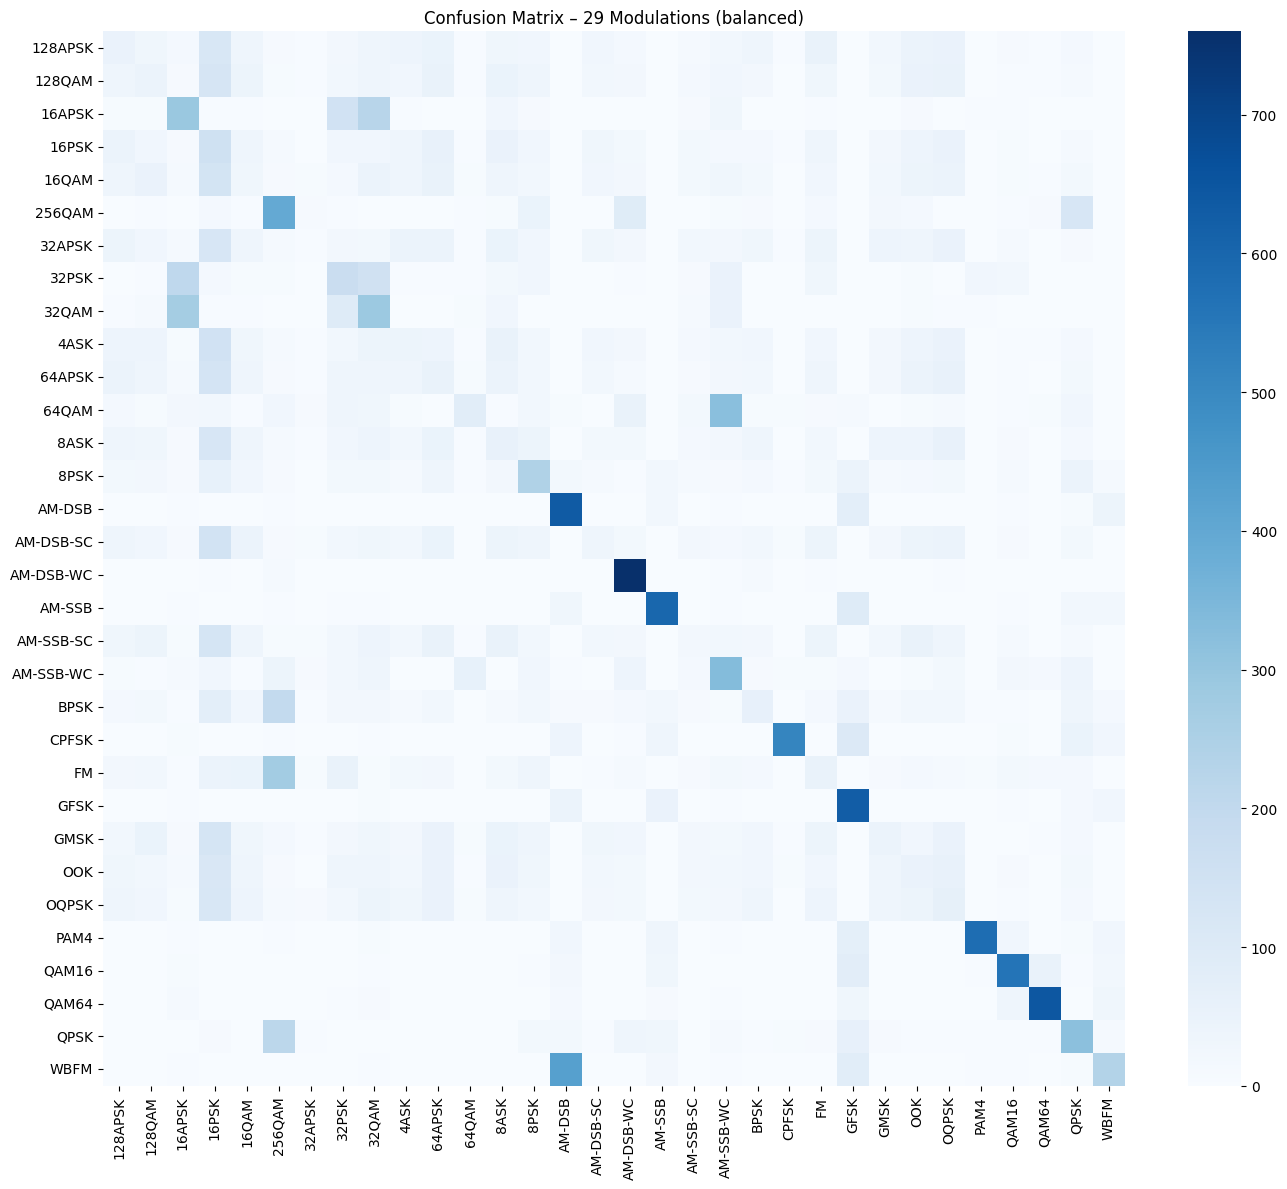

In [3]:
# ==============================================================
#  Balanced end-to-end training – 29 modulation classes
# ==============================================================

import h5py, ast, random, pickle, numpy as np, tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Softmax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from scipy.signal import resample
import matplotlib.pyplot as plt, seaborn as sns

# ---------------- hyper-parameters you may tweak ----------------
MAX_PER_CLASS   = 3000   # cap stored samples per class
SAMPLES_FOR_MEAN = 200   # to initialise prototype
BATCH_SIZE       = 512
BATCHES_PER_EPOCH= 400
WARM_EPOCHS      = 5      # first epochs with backbone partially frozen
TOTAL_EPOCHS     = 40
LR_HEAD          = 3e-4
LR_BACKBONE      = 3e-5   # lower LR for backbone
TEST_PER_CLASS   = 800
# ---------------------------------------------------------------

#  register Lambda used inside saved model ----------------------
@tf.keras.utils.register_keras_serializable(package="custom")
def downsample_1024_to_128(x):
    x4 = tf.expand_dims(x, -1)
    return tf.squeeze(tf.image.resize(x4, [128,3]), -1)

# ---------------- load backbone --------------------------------
full = load_model("transfer_model_full.keras",
                  custom_objects={"downsample_1024_to_128": downsample_1024_to_128},
                  compile=False)

dense_relu = next(l for l in reversed(full.layers)
                  if isinstance(l, tf.keras.layers.Dense)
                  and l.activation == tf.keras.activations.relu)

backbone = Model(full.input, dense_relu.output, name="backbone")
embed_dim = dense_relu.units

# freeze lowest LSTM for warm-up
first_lstm = next(l for l in backbone.layers if isinstance(l, tf.keras.layers.LSTM))
first_lstm.trainable = False

# ---------------- helper ---------------------------------------------------
def up_128_to_1024(x128):
    return resample(x128, 1024, axis=0)

# ---------------- load 2016 (all SNR) --------------------------------------
with open("RML2016.10a_dict.pkl","rb") as f:
    d16 = pickle.load(f, encoding="latin1")

legacy = ['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK',
          'PAM4','QAM16','QAM64','QPSK','WBFM']

per_cls = {c: [] for c in legacy}
for (mod,snr), sigs in d16.items():
    for sig in sigs:
        x128 = np.hstack([np.vstack([sig[0],sig[1]]).T, np.full((128,1), snr)])
        per_cls.setdefault(mod, []).append(up_128_to_1024(x128))

# ---------------- load 2018 high-SNR --------------------------------------
def load18(h5, txt, rng=(12,20)):
    names = [n.strip("',[] ") for n in ast.literal_eval(open(txt).read().replace("classes =", ""))]
    bank = {c: [] for c in names}
    with h5py.File(h5) as f:
        X,Y,Z = f["X"][:], f["Y"][:], f["Z"][:]
    for i in range(len(X)):
        s = int(Z[i][0])
        if rng[0]<=s<=rng[1]:
            cls = names[int(Y[i].argmax())]
            bank[cls].append(np.hstack([X[i], np.full((1024,1), s)]))
    return bank
per18 = load18("RML2018/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5",
               "RML2018/2018.01/classes.txt")

for k,v in per18.items():
    per_cls.setdefault(k, []).extend(v)

# keep ≤ MAX_PER_CLASS each class
for k in per_cls:
    random.shuffle(per_cls[k])
    per_cls[k] = per_cls[k][:MAX_PER_CLASS]

all_classes = sorted(per_cls.keys())
n_classes   = len(all_classes)
cls_index   = {c:i for i,c in enumerate(all_classes)}

print("Classes:", n_classes, all_classes[:10], "...")

# -------------- prototype layer -------------------------------------------
class Proto(Layer):
    def __init__(self, mat): super().__init__(); self.p=tf.Variable(mat, trainable=True)
    def call(self,x):
        return tf.matmul(tf.nn.l2_normalize(x,-1),
                         tf.nn.l2_normalize(self.p,-1), transpose_b=True)

# -------------- initial prototype matrix (mean of 200 samples) ------------
means=[]
for c in all_classes:
    subset=per_cls[c][:SAMPLES_FOR_MEAN]
    emb = backbone(np.asarray(subset), training=False)
    means.append(tf.reduce_mean(emb,0))
proto_mat=tf.stack(means)   # (29,128)

# -------------- build full model ------------------------------------------
inp = Input(shape=(1024,3))
emb = backbone(inp)
log = Proto(proto_mat)(emb)
out = Softmax()(log)
model = Model(inp,out)

# different LR for backbone vs head
opt = Adam(LR_HEAD, beta_1=0.5, beta_2=0.999)
for v in backbone.trainable_variables:
    v._keras_history[0].optimizer = Adam(LR_BACKBONE)

model.compile(opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# -------------- training loop ---------------------------------------------
for epoch in range(TOTAL_EPOCHS):
    for _ in range(BATCHES_PER_EPOCH):
        xs,ys=[],[]
        take = BATCH_SIZE//n_classes
        for c in all_classes:
            xs.extend(random.choices(per_cls[c], k=take))
            ys.extend([cls_index[c]]*take)
        xs,ys=np.asarray(xs),np.asarray(ys)
        model.train_on_batch(xs,ys)
    print(f"Epoch {epoch+1}/{TOTAL_EPOCHS} complete")
    if epoch+1==WARM_EPOCHS:
        first_lstm.trainable=True
        print("➡️  Unfroze first LSTM layer; full backbone now trainable")

# -------------- balanced evaluation ---------------------------------------
X_test,y_test=[],[]
for c in all_classes:
    X_test.extend(per_cls[c][:TEST_PER_CLASS])
    y_test.extend([cls_index[c]]*TEST_PER_CLASS)
X_test,y_test=np.asarray(X_test),np.asarray(y_test)

pred=np.argmax(model.predict(X_test,verbose=0),1)
acc =(pred==y_test).mean()
print(f"\nBalanced accuracy on {n_classes} classes: {acc:.3f}")

print("\nFull classification report:")
print(classification_report(y_test,pred,
      labels=range(n_classes), target_names=all_classes, zero_division=0))

cm=confusion_matrix(y_test,pred,labels=range(n_classes))
plt.figure(figsize=(14,12))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=all_classes, yticklabels=all_classes)
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.title("Confusion Matrix – 29 Modulations (balanced)")
plt.tight_layout(); plt.show()


Epoch 01/60 – balanced acc 0.334 – lr 3.00e-04
Epoch 02/60 – balanced acc 0.340 – lr 2.99e-04
Epoch 03/60 – balanced acc 0.350 – lr 2.98e-04
Epoch 04/60 – balanced acc 0.359 – lr 2.97e-04
Epoch 05/60 – balanced acc 0.367 – lr 2.95e-04
Epoch 06/60 – balanced acc 0.371 – lr 2.93e-04
Epoch 07/60 – balanced acc 0.369 – lr 2.91e-04
Epoch 08/60 – balanced acc 0.346 – lr 2.88e-04
Epoch 09/60 – balanced acc 0.371 – lr 2.84e-04
Epoch 10/60 – balanced acc 0.355 – lr 2.81e-04
✅ checkpoint saved → run_20250426_1244/epoch_10.keras
Epoch 11/60 – balanced acc 0.367 – lr 2.77e-04
Epoch 12/60 – balanced acc 0.348 – lr 2.73e-04
Epoch 13/60 – balanced acc 0.367 – lr 2.68e-04
Epoch 14/60 – balanced acc 0.355 – lr 2.63e-04
Epoch 15/60 – balanced acc 0.375 – lr 2.58e-04
Epoch 16/60 – balanced acc 0.359 – lr 2.53e-04
Epoch 17/60 – balanced acc 0.383 – lr 2.47e-04
Epoch 18/60 – balanced acc 0.359 – lr 2.41e-04
Epoch 19/60 – balanced acc 0.359 – lr 2.35e-04
Epoch 20/60 – balanced acc 0.389 – lr 2.29e-04
✅ chec

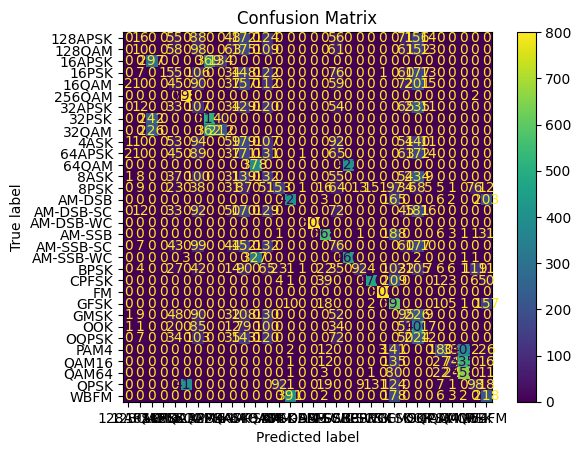

In [4]:
# ==============================================================
#  Visualise   +   Continue balanced training   (serialisable)
# ==============================================================

import os, json, math, datetime, random, numpy as np, tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, schedules
from tensorflow.keras.utils import plot_model
from sklearn.metrics import balanced_accuracy_score
import IPython.display as display
import matplotlib.pyplot as plt, seaborn as sns

# ------------------------------------------------------------------
# 0.  Draw architecture of CURRENT backbone+head (after rebuild)
# ------------------------------------------------------------------

@tf.keras.utils.register_keras_serializable(package="custom")
class Proto(Layer):
    """Cosine-similarity prototype layer that *is* serialisable."""
    def __init__(self, n_classes, embed_dim, **kw):
        super().__init__(**kw)
        self.n_classes = n_classes
        self.embed_dim = embed_dim
    def build(self, _):
        self.prototypes = self.add_weight(
            name="prototypes",
            shape=(self.n_classes, self.embed_dim),
            initializer="zeros",
            trainable=True)
    def call(self, x):
        x_n = tf.nn.l2_normalize(x, -1)
        p_n = tf.nn.l2_normalize(self.prototypes, -1)
        return tf.matmul(x_n, p_n, transpose_b=True)
    def get_config(self):
        cfg = super().get_config()
        cfg.update({"n_classes": self.n_classes, "embed_dim": self.embed_dim})
        return cfg

# --------- rebuild model with serialisable Proto -----------------
n_classes = len(all_classes)
embed_dim  = backbone.output_shape[-1]

inputs = Input(shape=(1024,3))
embeds = backbone(inputs)
logits = Proto(n_classes, embed_dim, name="proto")(embeds)
outputs = Softmax()(logits)
model   = Model(inputs, outputs, name="bal_gan_radio")

# initialise prototypes with existing means (uses per_cls from memory)
init_means = []
for c in all_classes:
    subset = per_cls[c][:200]
    init_means.append(tf.reduce_mean(backbone(np.asarray(subset), training=False), 0))
model.get_layer("proto").set_weights([tf.stack(init_means)])

# visualise
ARCH_PNG = "gan_radio_arch.png"
plot_model(model, to_file=ARCH_PNG, show_shapes=True, dpi=130)
display.Image(filename=ARCH_PNG)

# ------------------------------------------------------------------
# 1.  Training hyper-parameters
# ------------------------------------------------------------------
EXTRA_EPOCHS       = 60
BATCHES_PER_EPOCH  = 400
BATCH_SIZE         = 512
LR_START           = 3e-4
LR_MIN_FACTOR      = 0.05
CHECK_EVERY        = 10
RUN_DIR            = datetime.datetime.now().strftime("run_%Y%m%d_%H%M")
os.makedirs(RUN_DIR, exist_ok=True)

steps_total = EXTRA_EPOCHS * BATCHES_PER_EPOCH
lr_sched = schedules.CosineDecay(
    initial_learning_rate = LR_START,
    decay_steps           = steps_total,
    alpha                 = LR_MIN_FACTOR)

model.compile(
    optimizer = Adam(learning_rate=lr_sched, beta_1=0.5, beta_2=0.999),
    loss      = "sparse_categorical_crossentropy",
    metrics   = ["accuracy"])

# balanced batch helper -----------------------------------------------------
per_take = BATCH_SIZE // n_classes
def balanced_batch():
    xs, ys = [], []
    for c in all_classes:
        xs.extend(random.choices(per_cls[c], k=per_take))
        ys.extend([cls_index[c]] * per_take)
    return np.asarray(xs), np.asarray(ys)

# ------------------------------------------------------------------
# 2.  Training loop with checkpoints
# ------------------------------------------------------------------
hist = []
global_step = 0
for epoch in range(1, EXTRA_EPOCHS+1):
    for _ in range(BATCHES_PER_EPOCH):
        xb, yb = balanced_batch()
        model.train_on_batch(xb, yb)
        global_step += 1

    # quick balanced accuracy on last mini-batch
    preds = np.argmax(model.predict(xb, verbose=0), 1)
    bal_acc = balanced_accuracy_score(yb, preds)
    lr_now  = lr_sched(global_step).numpy()
    hist.append({"epoch": epoch, "bal_acc": float(bal_acc), "lr": float(lr_now)})
    print(f"Epoch {epoch:02d}/{EXTRA_EPOCHS} – balanced acc {bal_acc:.3f} – lr {lr_now:.2e}")

    if epoch % CHECK_EVERY == 0:
        path = f"{RUN_DIR}/epoch_{epoch:02d}.keras"
        model.save(path)
        with open(f"{RUN_DIR}/history.json","w") as f: json.dump(hist, f, indent=2)
        print(f"✅ checkpoint saved → {path}")

print("✔️  additional balanced training finished")


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Generate and plot a confusion matrix
# ------------------------------------------------------------------
# **Assumes** you have a held-out test set in X_test (shape [N,1024,3]) and y_test (shape [N], integer labels)

# 1) Run the model to get predictions
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

# 2) Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3) Plot using Matplotlib (no explicit color settings)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
